In [1]:
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import (
    calculate_weights,
    get_available_trackers,
    load_trackers,
    get_rebalance_dates,
    cap_long_only_weights,
    calc_covariance,
    cov_to_vols,
)
from backtest import backtest2
from entities import FX_TRACKER_DICT, EM_CDS_TRACKER_DICT

from bwlogger import StyleAdapter, basic_setup
from bwutils import open_file
from portfolio.construction import calculate_weights as calculate_weights_fh

c:\Users\pcampos\anaconda3\envs\bwgi\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# testing

In [4]:
backtest = long_fx_ew(cached_backtest=True)
backtest

date
2002-03-01    100.000000
2002-03-04    101.026173
2002-03-05    100.913870
2002-03-06    100.868916
2002-03-07    100.637249
                 ...    
2024-08-20    246.386113
2024-08-21    246.348672
2024-08-22    244.814511
2024-08-23    246.849126
2024-08-27    246.512507
Name: L-FX-EW, Length: 5524, dtype: float64

In [8]:
(backtest**-1*10000).rename("pnl_pct")

date
2002-03-01    100.000000
2002-03-04     98.984251
2002-03-05     99.094406
2002-03-06     99.138569
2002-03-07     99.366786
                 ...    
2024-08-20     40.586703
2024-08-21     40.592872
2024-08-22     40.847252
2024-08-23     40.510575
2024-08-27     40.565893
Name: pnl_pct, Length: 5524, dtype: float64

In [19]:
from run_backtest import long_cds_ew, long_fx_ew, long_cds_iv, long_fx_iv


trackers_ew = pd.concat([long_fx_ew(cached_backtest=True), long_cds_ew(cached_backtest=True)], axis=1, join="inner")
trackers_ew

,L-FX-EW,L-CDS-EW
date,,
2010-09-09,268.460044,100.000000
2010-09-10,268.711801,100.160017
2010-09-13,270.442820,100.531932
2010-09-14,271.761779,100.707180
2010-09-15,271.446886,100.948608
...,...,...
2024-08-20,246.386113,138.356758
2024-08-21,246.348672,138.330986
2024-08-22,244.814511,138.154760


In [34]:
long

date
2010-09-09    268.460044
2010-09-10    268.711801
2010-09-13    270.442820
2010-09-14    271.761779
2010-09-15    271.446886
                 ...    
2024-08-20    246.386113
2024-08-21    246.348672
2024-08-22    244.814511
2024-08-23    246.849126
2024-08-27    246.512507
Name: L-FX-EW, Length: 3428, dtype: float64

In [46]:
short

date
2010-09-09    268.460044
2010-09-10    268.711801
2010-09-13    270.442820
2010-09-14    271.761779
2010-09-15    271.446886
                 ...    
2024-08-20    246.386113
2024-08-21    246.348672
2024-08-22    244.814511
2024-08-23    246.849126
2024-08-27    246.512507
Name: L-FX-EW, Length: 3428, dtype: float64

In [59]:
long = trackers_ew.iloc[:, 1]
short = trackers_ew.iloc[:, 0]
long_return = np.log(long).diff(21)
short_return = np.log(short).diff(21)
pd.Series(
    {long.name: 1, short.name: -long_return.cov(short_return) / short_return.var()}
)

L-CDS-EW    1.000000
L-FX-EW    -0.602032
dtype: float64

date
2010-09-09         NaN
2010-09-10    0.001599
2010-09-13    0.005305
2010-09-14    0.007047
2010-09-15    0.009441
                ...   
2024-08-20    0.324665
2024-08-21    0.324479
2024-08-22    0.323204
2024-08-23    0.325373
2024-08-27    0.326920
Name: L-CDS-EW, Length: 3428, dtype: float64

# Plot

In [9]:
FOLDER = Path(
    "C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests"
)
list_series = []

In [12]:
file_paths = list(FOLDER.glob("*.xlsx"))

In [60]:
FOLDER = Path("C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests")
list_series = []
for file_path in FOLDER.glob("*.xlsx"):
    s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]
    s_backtest.name = file_path.stem
    list_series.append(s_backtest)
df_backtest = pd.concat(list_series, axis=1)


C:\Users\pcampos\AppData\Local\Temp\ipykernel_30388\822336325.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(
C:\Users\pcampos\AppData\Local\Temp\ipykernel_30388\822336325.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(


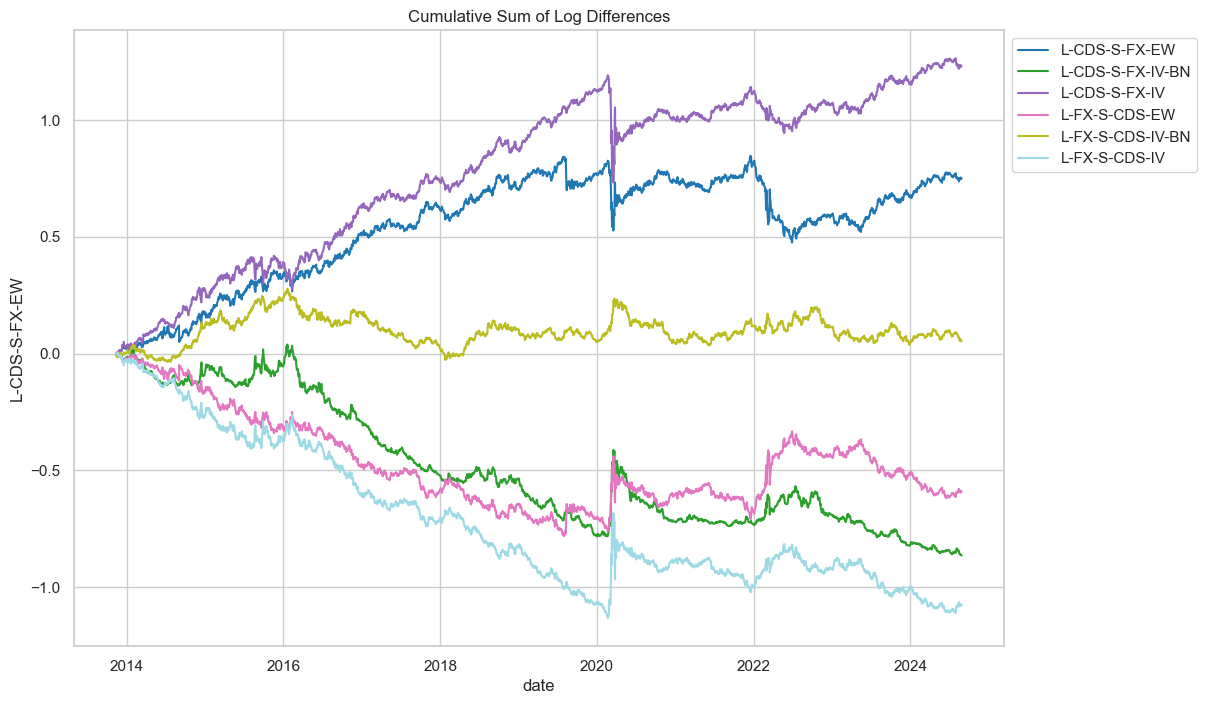

In [61]:
import seaborn as sns
# Assuming df_backtest is already defined
sns.set(style="whitegrid")
data = (
    np.log(df_backtest.dropna(how="any"))
    .diff(1)
    .cumsum()
)
# Create the plot
colors = plt.cm.get_cmap(
    "tab20", len(data.columns)
)  # Get a colormap with enough colors

# Create the plot
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap(
    "tab20", len(data.columns)
)  # Get a colormap with enough colors

for i, column in enumerate(data.columns):
    sns.lineplot(data=data[column], color=colors(i), label=column)

# Add legend and display the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Cumulative Sum of Log Differences")
plt.show()